<a href="https://colab.research.google.com/github/thamonS/Data-_Warehouse_Big_Data_Analytics/blob/main/firefox_Taxi_Data_Preprocessing_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pyarrow.parquet as pq
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calander
import warnings

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 30)
color = sns.color_palette("tab10")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trips = pq.read_table('/content/drive/MyDrive/Bigdata/july/yellow_tripdata_2023-07.parquet')
trips = trips.to_pandas()
data = trips

In [ ]:
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-07-01 00:29:59,2023-07-01 00:40:15,1.0,1.80,1.0,N,140,263,1,12.10,3.5,0.5,5.10,0.0,1.0,22.20,2.5,0.0
1,2,2023-07-01 00:03:25,2023-07-01 00:23:44,1.0,2.31,1.0,N,163,163,2,19.10,1.0,0.5,0.00,0.0,1.0,24.10,2.5,0.0
2,2,2023-07-01 00:38:29,2023-07-01 00:48:53,1.0,2.36,1.0,N,142,262,1,13.50,1.0,0.5,3.70,0.0,1.0,22.20,2.5,0.0
3,2,2023-07-01 00:14:16,2023-07-01 00:29:13,1.0,4.36,1.0,N,68,24,1,19.80,1.0,0.5,4.96,0.0,1.0,29.76,2.5,0.0
4,1,2023-07-01 00:11:15,2023-07-01 00:20:47,0.0,1.60,1.0,N,161,107,1,11.40,3.5,0.5,3.25,0.0,1.0,19.65,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907103,2,2023-07-31 23:18:11,2023-07-31 23:18:23,NaN,0.00,NaN,None,106,106,0,21.58,0.0,0.5,0.00,0.0,1.0,23.08,NaN,NaN
2907104,2,2023-07-31 23:29:31,2023-07-31 23:51:17,NaN,4.97,NaN,None,238,243,0,22.12,0.0,0.5,0.00,0.0,1.0,23.62,NaN,NaN
2907105,2,2023-07-31 23:16:57,2023-07-31 23:17:25,NaN,0.03,NaN,None,141,141,0,23.93,0.0,0.5,0.00,0.0,1.0,27.93,NaN,NaN
2907106,2,2023-07-31 23:29:00,2023-07-31 23:46:00,NaN,3.24,NaN,None,65,62,0,9.54,0.0,0.5,3.00,0.0,1.0,14.04,NaN,NaN


In [ ]:
# extract day and time, the calculate the duration of the trip
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
data['date'] = data['tpep_pickup_datetime'].dt.normalize()
data['time'] = data['tpep_pickup_datetime'].dt.hour
data['weekday'] = data['date'].dt.day_name()
data['duration'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']
data['duration'] = data['duration'] / np.timedelta64(1, 'm')

In [ ]:
# identifying holidays
cal = calander()
holidays = cal.holidays(start='2023-01-01', end='2023-12-31')
data['holiday'] = data['date'].isin(holidays)
data['week'] = data['date'].dt.dayofweek
data.loc[data['week'] >= 5, 'day_type'] = "weekend"
data.loc[data['week'] < 5, 'day_type'] = "workday"
data.loc[data['holiday'] == True, 'day_type'] = "holiday"
data = data.drop(['holiday', 'week'], axis=1)

In [ ]:
# calculate tip percentage using tip amount and total amount
data['tip_percent'] = (data.tip_amount / data.total_amount) * 100

In [ ]:
# classify a trip's time slot

def time_slots(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,17):
        return 'Afternoon'
    elif x in range(17,22):
        return 'Evening'
    else:
        return 'Late Night'

data['time_desc'] = data['time'].apply(time_slots)

In [ ]:
# drop features that we are not interested in
data = data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag', 'extra', 'mta_tax', 'improvement_surcharge'], axis=1)

<Axes: xlabel='trip_distance', ylabel='Density'>

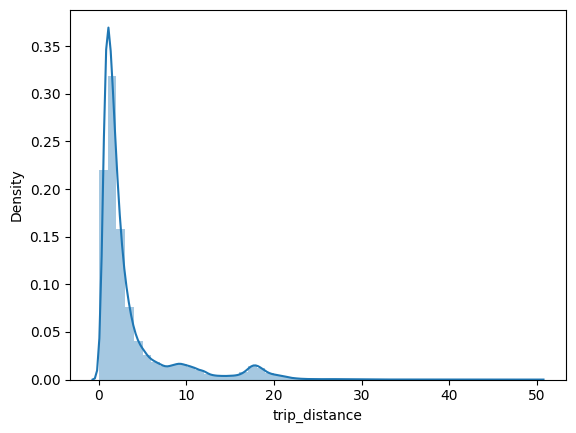

In [ ]:
sns.distplot(data[(data['trip_distance'] > 0) & (data['trip_distance'] <= 50)]['trip_distance'])

<Axes: xlabel='duration', ylabel='Density'>

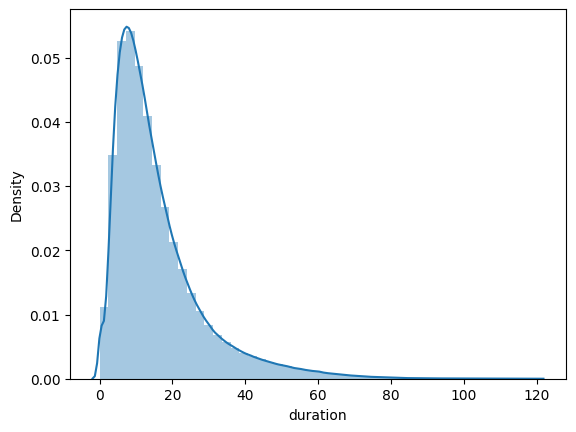

In [ ]:
sns.distplot(data[(data['duration'] > 0) & (data['duration'] < 120)]['duration'])

<Axes: xlabel='fare_amount', ylabel='Density'>

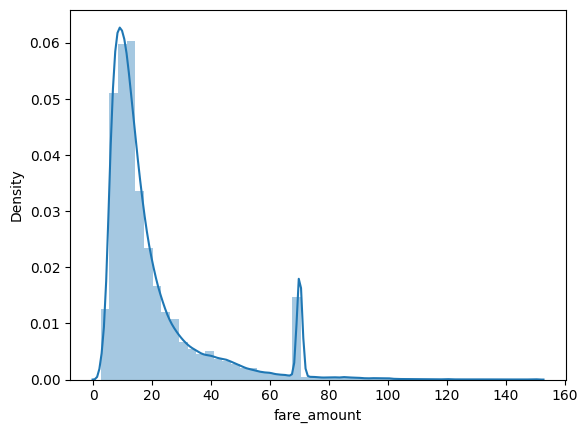

In [ ]:
sns.distplot(data[(data['fare_amount'] >= 2.5)&(data['fare_amount'] <= 150)]['fare_amount'])

<Axes: xlabel='tip_amount', ylabel='Density'>

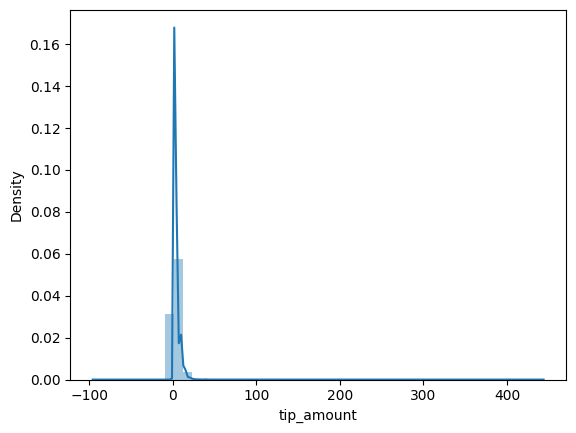

In [ ]:
sns.distplot(data.tip_amount)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2907108 entries, 0 to 2907107
Data columns (total 20 columns):
 #   Column                Dtype         
---  ------                -----         
 0   VendorID              int32         
 1   passenger_count       float64       
 2   trip_distance         float64       
 3   RatecodeID            float64       
 4   PULocationID          int32         
 5   DOLocationID          int32         
 6   payment_type          int64         
 7   fare_amount           float64       
 8   tip_amount            float64       
 9   tolls_amount          float64       
 10  total_amount          float64       
 11  congestion_surcharge  float64       
 12  Airport_fee           float64       
 13  date                  datetime64[us]
 14  time                  int32         
 15  weekday               object        
 16  duration              float64       
 17  day_type              object        
 18  tip_percent           float64       
 19  

In [ ]:
# remove invalid data
# passenger == 0
data = data[(data['passenger_count'] > 0) & (data['passenger_count'] < 7)]

# trip_distance <= 0
data = data[(data['trip_distance'] > 0) & (data['trip_distance'] <= 100)]

# exclude duration longer than 180 mins
data = data[(data['duration'] > 0) & (data['duration'] <= 180)]

# payment method other than cash and credit card
data = data[(data['payment_type'] != 3) & (data['payment_type'] != 4) & (data['payment_type'] != 5) & (data['payment_type'] != 6)]

# exclude instances with fare amount less than 2.5
data = data[(data['fare_amount'] >= 2.5) & (data['fare_amount'] <= 250)]

# remove trips with tip precentage over 50%
data = data[(data['tip_percent'] >= 0) & (data['tip_percent'] <= 50)]

# PU and DO location id not within NYC taxi zone
data = data[(data['PULocationID'] >= 1) & (data['PULocationID'] <= 263) & (data['DOLocationID'] >= 1) & (data['DOLocationID'] <= 263)]

In [ ]:
# convert passenger amount into three level
def passenger_convert(row):
    if (row >= 1) & (row <= 2):
        val = "small"
    elif (row > 2) & (row < 5):
        val = "medium"
    else:
        val = "high"
    return val

data['passenger_count'] = data['passenger_count'].apply(passenger_convert)

In [ ]:
data['passenger_count'].value_counts()

,count
passenger_count,
small,2391399
medium,185748
high,58054


## Weather

In [ ]:
weather = pd.read_csv('/content/drive/MyDrive/Bigdata/New York City,USA 2023-01-01 to 2023-12-31.csv')
weather

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,...,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"New York City,USA",2023-01-01,12.4,9.7,11.1,12.4,8.0,11.0,4.4,65.6,0.307,100,12.50,rain,0.0,...,272.8,1012.2,41.5,15.1,96.4,8.4,4,10,2023-01-01T07:20:12,2023-01-01T16:39:10,0.32,"Rain, Partially cloudy",Becoming cloudy in the afternoon with early mo...,rain,"72505394728,KEWR,KLGA,72502014734,F8726,KNYC,F..."
1,"New York City,USA",2023-01-02,13.5,8.2,11.1,13.5,6.7,10.8,4.3,63.3,0.564,100,12.50,rain,0.0,...,254.3,1019.3,61.7,15.5,43.8,3.6,3,10,2023-01-02T07:20:17,2023-01-02T16:40:01,0.35,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"72505394728,KEWR,KLGA,72502014734,F8726,KNYC,F..."
2,"New York City,USA",2023-01-03,13.1,8.2,10.7,13.1,7.3,10.5,8.8,88.3,9.908,100,29.17,rain,0.0,...,87.5,1014.4,91.6,8.8,16.2,1.5,1,10,2023-01-03T07:20:21,2023-01-03T16:40:53,0.39,"Rain, Overcast",Cloudy skies throughout the day with rain in t...,rain,"72505394728,KEWR,KLGA,72502014734,KNYC,F1417,7..."
3,"New York City,USA",2023-01-04,18.7,9.6,14.3,18.7,8.1,14.2,10.9,80.6,0.459,100,16.67,rain,0.0,...,192.9,1009.9,72.3,13.2,59.1,5.1,3,10,2023-01-04T07:20:22,2023-01-04T16:41:48,0.42,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"72505394728,KEWR,KLGA,72502014734,F8726,KNYC,F..."
4,"New York City,USA",2023-01-05,9.8,7.4,8.8,9.1,4.8,7.5,7.4,90.5,0.386,100,12.50,rain,0.0,...,57.2,1013.4,100.0,9.2,26.9,2.3,1,10,2023-01-05T07:20:21,2023-01-05T16:42:43,0.46,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"72505394728,KEWR,KLGA,72502014734,F8726,KNYC,F..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,"New York City,USA",2023-12-27,9.2,7.0,8.0,8.1,5.2,6.6,6.1,88.3,5.205,100,25.00,rain,0.0,...,48.1,1017.9,99.9,8.0,28.5,2.5,2,10,2023-12-27T07:19:05,2023-12-27T16:35:10,0.52,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"72505394728,KEWR,KLGA,72502014734,F1417,KNYC,7..."
361,"New York City,USA",2023-12-28,12.5,9.3,10.5,12.5,6.5,9.5,9.0,90.8,34.779,100,70.83,rain,0.0,...,48.8,1005.5,99.9,8.2,15.4,1.3,1,10,2023-12-28T07:19:23,2023-12-28T16:35:52,0.55,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"72505394728,KEWR,KLGA,72502014734,F1417,KNYC,7..."
362,"New York City,USA",2023-12-29,12.9,8.5,9.9,12.9,6.4,9.4,6.1,78.1,0.966,100,16.67,rain,0.0,...,271.8,1004.4,85.5,11.8,87.7,7.4,5,10,2023-12-29T07:19:38,2023-12-29T16:36:36,0.59,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"72505394728,KEWR,KLGA,72502014734,F1417,KNYC,7..."
363,"New York City,USA",2023-12-30,8.3,4.0,6.2,6.8,0.6,3.5,-0.6,61.5,0.000,0,0.00,NaN,0.0,...,273.8,1004.3,71.1,16.0,43.4,3.8,3,10,2023-12-30T07:19:51,2023-12-30T16:37:22,0.62,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72505394728,KEWR,KLGA,72502014734,F1417,KNYC,7..."


In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              365 non-null    object 
 1   datetime          365 non-null    object 
 2   tempmax           365 non-null    float64
 3   tempmin           365 non-null    float64
 4   temp              365 non-null    float64
 5   feelslikemax      365 non-null    float64
 6   feelslikemin      365 non-null    float64
 7   feelslike         365 non-null    float64
 8   dew               365 non-null    float64
 9   humidity          365 non-null    float64
 10  precip            365 non-null    float64
 11  precipprob        365 non-null    int64  
 12  precipcover       365 non-null    float64
 13  preciptype        147 non-null    object 
 14  snow              365 non-null    float64
 15  snowdepth         365 non-null    float64
 16  windgust          365 non-null    float64
 1

In [ ]:
# prompt: select  temp and datetime the rename temp tp avg_temp

weather = weather[['datetime', 'temp', 'precip', 'windspeed', 'snow', 'snowdepth']]
weather = weather.rename(columns={'temp': 'avg_temp'})
weather


,datetime,avg_temp,precip,windspeed,snow,snowdepth
0,2023-01-01,11.1,0.307,21.5,0.0,0.0
1,2023-01-02,11.1,0.564,12.3,0.0,0.0
2,2023-01-03,10.7,9.908,12.3,0.0,0.0
3,2023-01-04,14.3,0.459,14.6,0.0,0.0
4,2023-01-05,8.8,0.386,14.0,0.0,0.0
...,...,...,...,...,...,...
360,2023-12-27,8.0,5.205,18.1,0.0,0.0
361,2023-12-28,10.5,34.779,26.9,0.0,0.0
362,2023-12-29,9.9,0.966,23.4,0.0,0.0
363,2023-12-30,6.2,0.000,19.8,0.0,0.0


In [ ]:
# prompt: convert datetime to datetime64[us]
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather['datetime'] = weather['datetime'].astype('datetime64[us]')

In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   365 non-null    datetime64[us]
 1   avg_temp   365 non-null    float64       
 2   precip     365 non-null    float64       
 3   windspeed  365 non-null    float64       
 4   snow       365 non-null    float64       
 5   snowdepth  365 non-null    float64       
dtypes: datetime64[us](1), float64(5)
memory usage: 17.2 KB


In [ ]:
# merge weather dataset and taxi dataset
data = pd.DataFrame(pd.merge(data, weather, left_on='date', right_on='datetime')).drop('datetime', axis=1)

In [ ]:
data

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,congestion_surcharge,Airport_fee,date,time,weekday,duration,day_type,tip_percent,time_desc,avg_temp,precip,windspeed,snow,snowdepth
0,1,small,1.80,1.0,140,263,1,12.1,5.10,0.00,22.20,2.5,0.00,2023-07-01,0,Saturday,10.266667,weekend,22.972973,Late Night,24.0,0.0,22.3,0.0,0.0
1,2,small,2.31,1.0,163,163,2,19.1,0.00,0.00,24.10,2.5,0.00,2023-07-01,0,Saturday,20.316667,weekend,0.000000,Late Night,24.0,0.0,22.3,0.0,0.0
2,2,small,2.36,1.0,142,262,1,13.5,3.70,0.00,22.20,2.5,0.00,2023-07-01,0,Saturday,10.400000,weekend,16.666667,Late Night,24.0,0.0,22.3,0.0,0.0
3,2,small,4.36,1.0,68,24,1,19.8,4.96,0.00,29.76,2.5,0.00,2023-07-01,0,Saturday,14.950000,weekend,16.666667,Late Night,24.0,0.0,22.3,0.0,0.0
4,2,small,8.67,1.0,138,186,1,38.7,7.00,6.55,64.00,2.5,1.75,2023-07-01,0,Saturday,24.700000,weekend,10.937500,Late Night,24.0,0.0,22.3,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635195,1,medium,2.70,1.0,234,142,2,14.9,0.00,0.00,19.90,2.5,0.00,2023-07-31,23,Monday,12.750000,workday,0.000000,Late Night,24.1,0.0,17.1,0.0,0.0
2635196,1,small,10.50,1.0,50,95,2,43.6,0.00,6.55,55.15,2.5,0.00,2023-07-31,23,Monday,27.916667,workday,0.000000,Late Night,24.1,0.0,17.1,0.0,0.0
2635197,2,small,3.62,1.0,48,263,1,19.8,4.96,0.00,29.76,2.5,0.00,2023-07-31,23,Monday,16.233333,workday,16.666667,Late Night,24.1,0.0,17.1,0.0,0.0
2635198,2,small,1.23,1.0,48,68,2,7.9,0.00,0.00,12.90,2.5,0.00,2023-07-31,23,Monday,4.566667,workday,0.000000,Late Night,24.1,0.0,17.1,0.0,0.0


In [ ]:
# Identify pickup and dropoff borough
zone_df = pd.read_csv('/content/drive/MyDrive/Bigdata/taxi_zone_lookup.csv')
data = pd.DataFrame(pd.merge(data, zone_df[['LocationID', 'Borough']], left_on='PULocationID', right_on='LocationID')).drop('LocationID', axis=1)
data = data.rename({'Borough':'PUborough'}, axis=1)
data = pd.DataFrame(pd.merge(data, zone_df[['LocationID', 'Borough']], left_on='DOLocationID', right_on='LocationID')).drop('LocationID', axis=1)
data = data.rename({'Borough':'DOborough'}, axis=1)

In [ ]:
# Identify pick up and dropoff location thats from airport

data.loc[data['PULocationID'] == 132, 'PUborough'] = 'JFK'
data.loc[data['DOLocationID'] == 132, 'DOborough'] = 'JFK'
data.loc[data['PULocationID'] == 138, 'PUborough'] = 'LaGuardia'
data.loc[data['DOLocationID'] == 138, 'DOborough'] = 'LaGuardia'

In [ ]:
data

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,congestion_surcharge,Airport_fee,date,time,weekday,duration,day_type,tip_percent,time_desc,avg_temp,precip,windspeed,snow,snowdepth,PUborough,DOborough
0,1,small,1.80,1.0,140,263,1,12.1,5.10,0.00,22.20,2.5,0.00,2023-07-01,0,Saturday,10.266667,weekend,22.972973,Late Night,24.0,0.0,22.3,0.0,0.0,Manhattan,Manhattan
1,2,small,2.31,1.0,163,163,2,19.1,0.00,0.00,24.10,2.5,0.00,2023-07-01,0,Saturday,20.316667,weekend,0.000000,Late Night,24.0,0.0,22.3,0.0,0.0,Manhattan,Manhattan
2,2,small,2.36,1.0,142,262,1,13.5,3.70,0.00,22.20,2.5,0.00,2023-07-01,0,Saturday,10.400000,weekend,16.666667,Late Night,24.0,0.0,22.3,0.0,0.0,Manhattan,Manhattan
3,2,small,4.36,1.0,68,24,1,19.8,4.96,0.00,29.76,2.5,0.00,2023-07-01,0,Saturday,14.950000,weekend,16.666667,Late Night,24.0,0.0,22.3,0.0,0.0,Manhattan,Manhattan
4,2,small,8.67,1.0,138,186,1,38.7,7.00,6.55,64.00,2.5,1.75,2023-07-01,0,Saturday,24.700000,weekend,10.937500,Late Night,24.0,0.0,22.3,0.0,0.0,LaGuardia,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635195,1,medium,2.70,1.0,234,142,2,14.9,0.00,0.00,19.90,2.5,0.00,2023-07-31,23,Monday,12.750000,workday,0.000000,Late Night,24.1,0.0,17.1,0.0,0.0,Manhattan,Manhattan
2635196,1,small,10.50,1.0,50,95,2,43.6,0.00,6.55,55.15,2.5,0.00,2023-07-31,23,Monday,27.916667,workday,0.000000,Late Night,24.1,0.0,17.1,0.0,0.0,Manhattan,Queens
2635197,2,small,3.62,1.0,48,263,1,19.8,4.96,0.00,29.76,2.5,0.00,2023-07-31,23,Monday,16.233333,workday,16.666667,Late Night,24.1,0.0,17.1,0.0,0.0,Manhattan,Manhattan
2635198,2,small,1.23,1.0,48,68,2,7.9,0.00,0.00,12.90,2.5,0.00,2023-07-31,23,Monday,4.566667,workday,0.000000,Late Night,24.1,0.0,17.1,0.0,0.0,Manhattan,Manhattan


In [ ]:
data.to_csv('taxi_data_processed7.csv', index=False)

## Latitude Longtitude

In [ ]:
pip install geopandas

In [ ]:
data

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,congestion_surcharge,Airport_fee,date,time,weekday,duration,day_type,tip_percent,time_desc,avg_temp,precip,windspeed,snow,snowdepth,PUborough,DOborough
0,1,small,1.80,1.0,140,263,1,12.1,5.10,0.00,22.20,2.5,0.00,2023-07-01,0,Saturday,10.266667,weekend,22.972973,Late Night,24.0,0.0,22.3,0.0,0.0,Manhattan,Manhattan
1,2,small,2.31,1.0,163,163,2,19.1,0.00,0.00,24.10,2.5,0.00,2023-07-01,0,Saturday,20.316667,weekend,0.000000,Late Night,24.0,0.0,22.3,0.0,0.0,Manhattan,Manhattan
2,2,small,2.36,1.0,142,262,1,13.5,3.70,0.00,22.20,2.5,0.00,2023-07-01,0,Saturday,10.400000,weekend,16.666667,Late Night,24.0,0.0,22.3,0.0,0.0,Manhattan,Manhattan
3,2,small,4.36,1.0,68,24,1,19.8,4.96,0.00,29.76,2.5,0.00,2023-07-01,0,Saturday,14.950000,weekend,16.666667,Late Night,24.0,0.0,22.3,0.0,0.0,Manhattan,Manhattan
4,2,small,8.67,1.0,138,186,1,38.7,7.00,6.55,64.00,2.5,1.75,2023-07-01,0,Saturday,24.700000,weekend,10.937500,Late Night,24.0,0.0,22.3,0.0,0.0,LaGuardia,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635195,1,medium,2.70,1.0,234,142,2,14.9,0.00,0.00,19.90,2.5,0.00,2023-07-31,23,Monday,12.750000,workday,0.000000,Late Night,24.1,0.0,17.1,0.0,0.0,Manhattan,Manhattan
2635196,1,small,10.50,1.0,50,95,2,43.6,0.00,6.55,55.15,2.5,0.00,2023-07-31,23,Monday,27.916667,workday,0.000000,Late Night,24.1,0.0,17.1,0.0,0.0,Manhattan,Queens
2635197,2,small,3.62,1.0,48,263,1,19.8,4.96,0.00,29.76,2.5,0.00,2023-07-31,23,Monday,16.233333,workday,16.666667,Late Night,24.1,0.0,17.1,0.0,0.0,Manhattan,Manhattan
2635198,2,small,1.23,1.0,48,68,2,7.9,0.00,0.00,12.90,2.5,0.00,2023-07-31,23,Monday,4.566667,workday,0.000000,Late Night,24.1,0.0,17.1,0.0,0.0,Manhattan,Manhattan


In [ ]:
import geopandas as gpd
import zipfile
import pandas as pd

# Path to the zip file and .shp file inside
zip_path = '/content/drive/MyDrive/Bigdata/taxi_zones.zip'
shapefile_name = 'taxi_zones.shp'  # Name of the .shp file inside the zip

# Open the zip file and read the .shp file directly
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/shapefile_extracted')  # Extract to a temp folder

# Path to the extracted .shp file
shapefile_path = '/content/shapefile_extracted/' + shapefile_name

# Read the shapefile using geopandas
gdf = gpd.read_file(shapefile_path)

# Convert GeoDataFrame to a regular pandas DataFrame (if you don't need geometry)
df = pd.DataFrame(gdf.drop(columns='geometry'))  # Drop the 'geometry' column if not needed

# Display the DataFrame
print(df.head())


   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough  
0            EWR  
1         Queens  
2          Bronx  
3      Manhattan  
4  Staten Island  


In [ ]:
import geopandas as gpd
import os

# Set the config option to restore .shx file
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

# Try reading the file again
shapefile_path = '/content/drive/MyDrive/Bigdata/taxi_zones.shp'
taxi_zones = gpd.read_file(shapefile_path)

In [ ]:
print(taxi_zones)

                                              geometry
0    POLYGON ((933100.918 192536.086, 933091.011 19...
1    MULTIPOLYGON (((1033269.244 172126.008, 103343...
2    POLYGON ((1026308.77 256767.698, 1026495.593 2...
3    POLYGON ((992073.467 203714.076, 992068.667 20...
4    POLYGON ((935843.31 144283.336, 936046.565 144...
..                                                 ...
258  POLYGON ((1025414.782 270986.139, 1025138.624 ...
259  POLYGON ((1011466.966 216463.005, 1011545.889 ...
260  POLYGON ((980555.204 196138.486, 980570.792 19...
261  MULTIPOLYGON (((999804.795 224498.527, 999824....
262  POLYGON ((997493.323 220912.386, 997355.264 22...

[263 rows x 1 columns]


In [ ]:
taxi_zones

,geometry
0,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,"POLYGON ((935843.31 144283.336, 936046.565 144..."
...,...
258,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


In [ ]:
# Merge both DataFrames on their index
merged_df = pd.concat([df, taxi_zones], axis=1)

# Display the merged DataFrame
merged_df


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


In [ ]:
# prompt: merge data with merged_df by and add 2 new columns based on PULocationID and DOLocationID
# Merge data with merged_df based on PULocationID
data = pd.merge(data, merged_df[['LocationID', 'zone']], left_on='PULocationID', right_on='LocationID', how='left')
data = data.rename(columns={'zone': 'PUzone'})
data = data.drop('LocationID', axis=1)

# Merge data with merged_df based on DOLocationID
data = pd.merge(data, merged_df[['LocationID', 'zone']], left_on='DOLocationID', right_on='LocationID', how='left')
data = data.rename(columns={'zone': 'DOzone'})
data = data.drop('LocationID', axis=1)

data


,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,congestion_surcharge,Airport_fee,date,time,weekday,duration,day_type,tip_percent,time_desc,avg_temp,precip,windspeed,snow,snowdepth,PUborough,DOborough,PUzone,DOzone
0,1,small,1.80,1.0,140,263,1,12.1,5.10,0.00,22.20,2.5,0.00,2023-07-01,0,Saturday,10.266667,weekend,22.972973,Late Night,24.0,0.0,22.3,0.0,0.0,Manhattan,Manhattan,Lenox Hill East,Yorkville West
1,2,small,2.31,1.0,163,163,2,19.1,0.00,0.00,24.10,2.5,0.00,2023-07-01,0,Saturday,20.316667,weekend,0.000000,Late Night,24.0,0.0,22.3,0.0,0.0,Manhattan,Manhattan,Midtown North,Midtown North
2,2,small,2.36,1.0,142,262,1,13.5,3.70,0.00,22.20,2.5,0.00,2023-07-01,0,Saturday,10.400000,weekend,16.666667,Late Night,24.0,0.0,22.3,0.0,0.0,Manhattan,Manhattan,Lincoln Square East,Yorkville East
3,2,small,4.36,1.0,68,24,1,19.8,4.96,0.00,29.76,2.5,0.00,2023-07-01,0,Saturday,14.950000,weekend,16.666667,Late Night,24.0,0.0,22.3,0.0,0.0,Manhattan,Manhattan,East Chelsea,Bloomingdale
4,2,small,8.67,1.0,138,186,1,38.7,7.00,6.55,64.00,2.5,1.75,2023-07-01,0,Saturday,24.700000,weekend,10.937500,Late Night,24.0,0.0,22.3,0.0,0.0,LaGuardia,Manhattan,LaGuardia Airport,Penn Station/Madison Sq West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2636073,1,medium,2.70,1.0,234,142,2,14.9,0.00,0.00,19.90,2.5,0.00,2023-07-31,23,Monday,12.750000,workday,0.000000,Late Night,24.1,0.0,17.1,0.0,0.0,Manhattan,Manhattan,Union Sq,Lincoln Square East
2636074,1,small,10.50,1.0,50,95,2,43.6,0.00,6.55,55.15,2.5,0.00,2023-07-31,23,Monday,27.916667,workday,0.000000,Late Night,24.1,0.0,17.1,0.0,0.0,Manhattan,Queens,Clinton West,Forest Hills
2636075,2,small,3.62,1.0,48,263,1,19.8,4.96,0.00,29.76,2.5,0.00,2023-07-31,23,Monday,16.233333,workday,16.666667,Late Night,24.1,0.0,17.1,0.0,0.0,Manhattan,Manhattan,Clinton East,Yorkville West
2636076,2,small,1.23,1.0,48,68,2,7.9,0.00,0.00,12.90,2.5,0.00,2023-07-31,23,Monday,4.566667,workday,0.000000,Late Night,24.1,0.0,17.1,0.0,0.0,Manhattan,Manhattan,Clinton East,East Chelsea


In [ ]:
# prompt: merge data with merged_df by and add 2 new columns based on PULocationID and DOLocationID the values in each new added columns is geometry
# Merge data with merged_df based on PULocationID
data = pd.merge(data, merged_df[['LocationID', 'geometry']], left_on='PULocationID', right_on='LocationID', how='left')
data = data.rename(columns={'geometry': 'PUgeometry'})
data = data.drop('LocationID', axis=1)

# Merge data with merged_df based on DOLocationID
data = pd.merge(data, merged_df[['LocationID', 'geometry']], left_on='DOLocationID', right_on='LocationID', how='left')
data = data.rename(columns={'geometry': 'DOgeometry'})
data = data.drop('LocationID', axis=1)

# Display the updated DataFrame
data


,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,congestion_surcharge,Airport_fee,date,time,...,duration,day_type,tip_percent,time_desc,avg_temp,precip,windspeed,snow,snowdepth,PUborough,DOborough,PUzone,DOzone,PUgeometry,DOgeometry
0,1,small,1.80,1.0,140,263,1,12.1,5.10,0.00,22.20,2.5,0.00,2023-07-01,0,...,10.266667,weekend,22.972973,Late Night,24.0,0.0,22.3,0.0,0.0,Manhattan,Manhattan,Lenox Hill East,Yorkville West,"POLYGON ((995735.062 215619.835, 995670.105 21...","POLYGON ((997493.323 220912.386, 997355.264 22..."
1,2,small,2.31,1.0,163,163,2,19.1,0.00,0.00,24.10,2.5,0.00,2023-07-01,0,...,20.316667,weekend,0.000000,Late Night,24.0,0.0,22.3,0.0,0.0,Manhattan,Manhattan,Midtown North,Midtown North,"POLYGON ((989412.663 219020.943, 990045.841 21...","POLYGON ((989412.663 219020.943, 990045.841 21..."
2,2,small,2.36,1.0,142,262,1,13.5,3.70,0.00,22.20,2.5,0.00,2023-07-01,0,...,10.400000,weekend,16.666667,Late Night,24.0,0.0,22.3,0.0,0.0,Manhattan,Manhattan,Lincoln Square East,Yorkville East,"POLYGON ((989380.305 218980.247, 989359.803 21...","MULTIPOLYGON (((999804.795 224498.527, 999824...."
3,2,small,4.36,1.0,68,24,1,19.8,4.96,0.00,29.76,2.5,0.00,2023-07-01,0,...,14.950000,weekend,16.666667,Late Night,24.0,0.0,22.3,0.0,0.0,Manhattan,Manhattan,East Chelsea,Bloomingdale,"POLYGON ((983690.405 209040.369, 983550.612 20...","POLYGON ((995453.114 230274.267, 995312.583 23..."
4,2,small,8.67,1.0,138,186,1,38.7,7.00,6.55,64.00,2.5,1.75,2023-07-01,0,...,24.700000,weekend,10.937500,Late Night,24.0,0.0,22.3,0.0,0.0,LaGuardia,Manhattan,LaGuardia Airport,Penn Station/Madison Sq West,"MULTIPOLYGON (((1019904.219 225677.983, 102031...","POLYGON ((986752.603 210853.699, 986627.863 21..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637835,1,medium,2.70,1.0,234,142,2,14.9,0.00,0.00,19.90,2.5,0.00,2023-07-31,23,...,12.750000,workday,0.000000,Late Night,24.1,0.0,17.1,0.0,0.0,Manhattan,Manhattan,Union Sq,Lincoln Square East,"POLYGON ((987029.847 207022.299, 987048.27 206...","POLYGON ((989380.305 218980.247, 989359.803 21..."
2637836,1,small,10.50,1.0,50,95,2,43.6,0.00,6.55,55.15,2.5,0.00,2023-07-31,23,...,27.916667,workday,0.000000,Late Night,24.1,0.0,17.1,0.0,0.0,Manhattan,Queens,Clinton West,Forest Hills,"POLYGON ((985170.372 221087.389, 985817.17 220...","POLYGON ((1026559.225 208467.841, 1026590.157 ..."
2637837,2,small,3.62,1.0,48,263,1,19.8,4.96,0.00,29.76,2.5,0.00,2023-07-31,23,...,16.233333,workday,16.666667,Late Night,24.1,0.0,17.1,0.0,0.0,Manhattan,Manhattan,Clinton East,Yorkville West,"POLYGON ((986694.313 214463.846, 986568.184 21...","POLYGON ((997493.323 220912.386, 997355.264 22..."
2637838,2,small,1.23,1.0,48,68,2,7.9,0.00,0.00,12.90,2.5,0.00,2023-07-31,23,...,4.566667,workday,0.000000,Late Night,24.1,0.0,17.1,0.0,0.0,Manhattan,Manhattan,Clinton East,East Chelsea,"POLYGON ((986694.313 214463.846, 986568.184 21...","POLYGON ((983690.405 209040.369, 983550.612 20..."


In [ ]:
# prompt: convert data to csv file

data.to_csv('taxi_data_processed1.csv', index=False)
